# Mixture separationon single frequency bin

The goal of this notebook is to check whether it is possible to discrimate between different types of signals based on their respective learned models of a single frequency bin. In order to do so, the parameters from the `single_frequency_modelling_drilling.ipynb` and `single_frequency_modelling_speech.ipynb` notebooks are loaded. Furthermore, a dummy piece of audio is formed by interleaving segments of 0.5s of the original sound sources. Both models are used to perform a 1 step prediction and finally a hard classification is performed on the absolute prediction error.

From the prediction error it can be noted that this approach is capable of discriminating between signal sources based on the learned signal models. It should be noted that the approach is not ideal and should be considered a proof of concept. One problem that came up is that the predicted variance is always 1, I am not sure how to solve this. I suppose this is related to the learning of the process noise parameters which are both very large, leading to a mean/mode of approximately 1. It may be possible to let this process noise be free to be determined, since it contains information about the power of the signal from an analytical standpoint. 

Further exploration includes:
- using process noise parameter to learn signal gain
- create switching mechanism based on binomial multiplier
- allow for communication among all frequencies

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.AR
using LAR.DataAR
using FFTW

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [2]:
# signal preprocessing
sound_file_1 = "../data/drilling.wav"   # specify sound location of first mixture component
sound_file_2 = "../data/obama.wav"      # specify sound location of second mixture component
fs_desired = 8000                   # specify desired sampling frequency

# signal warping
nr_taps_warped = 32                  # number of taps of warped filter bank
z_pole = 0.4092                      # pole location of all-pass filter segments (0.5756 ~ approximation Bark scale)
window = rectangularwindow           # specify windowing function from fourier.jl file

# parameter loading
param_file_1 = "../inferred_values/drillingnoise_AR_20.h5"
param_file_2 = "../inferred_values/speech_AR_20.h5"

# inference and modelling
bin = 8                              # specify which bin to model (should be between 1 and half `nr_taps_warped`)
bin_c = "real"                       # specify whether to model the `real` or `imaginary` part
AR_order = 20                         # order of auto-regressive model
iterations = 3                       # number of iterations for variational message passing
Λ_meas = 1e10                        # assumed precision of measurement noise
;

## Load and preprocess data

In [3]:
# load and process first mixture component
x_1, fs_1 = wavread(sound_file_1, format="native")
fs_1 = Int(fs_1)
x_1 = x_1[20*fs_1+1:23*fs_1]
x_1 = resample(x_1, fs_desired/fs_1)
x_1 = 100*x_1/var(x_1)

# load and process second mixture component
x_2, fs_2 = wavread(sound_file_2, format="native")
fs_2 = Int(fs_2)
x_2 = x_2[20*fs_2+1:23*fs_2]
x_2 = resample(x_2, fs_desired/fs_2)
x_2 = 100*x_2/var(x_2)

# Combine signals through simple addition
x_tot = x_1 + x_2

# create time axis
t = collect((1:length(x_tot))/fs_desired)

# create audio players for demonstration
audioplayers(x_1, x_2, x_tot, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCVfEg869jxuyXjqLxEVnC8iNN6O1ZezLxFIUg7U6YdPUslG72mF6C9M7k+PGE7Xz3cuSA9gqi0vHSN/jxRw4+8uuaIu8QE7Tsuyds88qELPTmM47x10jC8VkULvGxvJTw2bS67XT35PJgVAbzFHLy8TscdvfVuhTv0zhY8hkZnO6VsiLyDJ9I7MqG3PHmMarzDCl27GITVO3XtZLy+2BC9bBezvKBYIDupdx89yEZourVOljzAXMI8lJoAvWwHvbrSl6M8XM1HukQu07s46tE8oHy+PK/3rbvB8ua8MnuYPHcJqryi0tU8O17vOwKXRDz52xm8nUoXPC7Al7x8Io+8H0e3POYZlzzfZva7kqdFO0KRCz0V+DG9p23ZPLi0lr22hqA8x+eoPFhd9LpSDgW9d997PJgSgLwpphu9zeYxPI9WU7xuiuY8gCwOvYYqHj1i5v68/QCivKuMEzuc6KW7Hll3vM2KODqC7zU9kgEXvVGheDw9Vq48jWLbPFL8eryHcOU7i0lTPYWhKr049Ds957uOO3oomrzTIMq8h63NPDRmkbygpD28PmFpPPtW6zyo7Xm89fgvvdq1Yj0drAM9gmuzvDDfMr2zDK+7MgyhvJH/k7wFqPw8vCDcPPfJKjyiUhW9giA+PMDu2TlATAG85i6VumxOkTzIv+86xyjMPJ/SZDzEDH281wY+uh+ftLzWjm08gW9CPFW3CD0G/nK8YBa2vG64mLz/M+I7pKkauxyb7zw0Sr+8tBdDvc0uC7s7Gxe99oXXujQyVzzoCjA8MjOpPB+s57u9Yoo6obbgOdr2+LxWjAo8bO+8PFDFD7wd6vc8BPQVPKMpLzx+4w+9Q8nbOjyxTDzvNB+8mK08vPZBzTy5Uog7CLkIve6KLD2B3uQ8YXaivIKpGLw86xE8zcfJu8ZnDr2Jzsm8CfPRPMYthD0lZQg9uPLkvMp8pLzWaMS8R+FivPfsIz0rfig957nvPOpBwrszBce88skMvZRvOb2bta068n8DPRTQubyCC108Dt4xuk16Tb2H+2e8HH/MOyd+n7zxUSq9+vybOxor3zx/4No8XL8hPFGvpry0Jia862ghvMu08bvcCMU7+KEjPUQZKTwVUFU9KhMTvVBvv7x6mGu7I5L5PDSBC71PMT49BXBZPJhsJTxjNw290xwhPNNyDz2Wa9c8ycm4vH5sHr3ZxqU8JC4dvSSiQjxIGNE8so2jPb3TFb0O55Y84yMTvWiZFb3zZ0a8vK39PBxJfDwR+m68xjERPX53pLzYRRG9gh32vCSiALzf2M08EqB/vRd93LqXKkM8pSBjO3+m/LuIy+g8MNSCPAj4TL3TNhC9Ecz2O5BnlTznE1W7lFdyPXb/ozx4lca7r5ATvIbKPjwHfow78TYdPSYKfrxfNg28E+qUvSaQATxFf0I8djdfPNNUx7x/iEw96amLu8/TMjzLwle9jQ2jvEABFT1NQ589Hr/ku/hWRb1Er5G70TMHvYPO7zzQZnY8vSNPPYIed7z2jyE80impvD/Wjjv/93m8S3KmOgbpTzy9KuA8Q6B3vSQWr7ytPha7d97TPK2Z+TyCrnK9QbSOvM9rNb3XYYC82Y7NPDz/YD21fsg8qtyrvOLpGbynfSK9Oy3kPEFnkLvOhRQ9hgUKPfuK8LyQFky9hAiEvPL6zLw2OBk92Gq+Pd2hnrwYa2a9SvUTvVhB9jzg/xI8mWCJu467HD0dhG48aK6HPILdab3Rkxo9LeQhO3dELToUPB09a1m/PJ6x97x7jUa9XNRWPBFLejzDTfg8Nf+lu03B5jwJxSy8rwM5vdGszrzRUTY9+UutO6MPeb1vaIA8vL6mOvCUIzvQcQi90uJ6PJ1xs7z5rx2936lkuxuEMrzYxck8t4AZvOnLrzy3QfA7cTKoPJtln7zkEi09v0w6O154fLzKxgM92aEgvBaNTDxoSa+8wKMqu7qDhbyM+Bu8KZcaPTSr0Dwqsj+9Fmn1u6r5L71FVOU8tUR3u0cJojyxvDo9dqIaPYA6+byzxV69sSwAPC9jizsUNqM8o1/wPBOj0DkHhYI8LL3ovFc1nbzBLP288SvePAgN4TxCwI288IMVuYIDBzwNHLQ7z1WtvJMLxrx1PRS9J1RuvKMyg7vPv9Q8luGJu46TIT0ZPPm8O1THvJM4pTv8mqy8WpFkPXcZMTwUSTI78JQMPBwj8bz/kQ26nQ+luwxVRz3z4J48YWg9vYi6pbyLpiA8zej2uw4GhDtF6Wc9ovJtu8om2ztvR669gE2Xuw1HlTze3RQ9qdWkPLyqDj1Vw488nNj8uyDZ7DsAWWa9iPFfvIpu6Dsw18c83niePCpCLT2W2GS8UXPwvMT7X739eMi8620GPAw9b7tV+Z28cG32PF1D3LwG1ee8zJoDO2EM4ruOSDo88pwhuwwLBTxhkcy72/O2u1bq1DzyZHU8TpBOvdxqxjwARwo97/rxPEqYFLzwtiU9/1FbO2RRO70J4RO94EkrPeNpCj1rgha8X2P9vAh4r7sb6Ue8EVUGvfDutzv4uS09zEFpPYULxLuY/oK83pzevH6XM7x94qY7rzpwPdFydLqa1C08uqKOvAdos7xN0se8l+QbPOf5T7xcH/C8aQGAPLnMHj3+Hcy8aZVPvG8MaLygv2e7m8acvIuS0btnqXE8zp+tvMfOxjxEKNQ7ywwJO/5BMb2swoY8gp3lu2TfxTykdVU8CRugPLzokry9LR66NE2DPP2tE7yfC3e84tlPPKeYpDzO2Ak9IJmQvM7a5LxB0ie7HDBCPXkJwbxxq9s8omWeuyZjJb1Ofiy7emuGOxA5ijuS/4s6zPkEPT1zhjxaiRA8jNPivBesWzyoTGS8eWlVvBAXxTzudUA7mdORu/uPFDzy9We87CQ6vCYWSb0JNcU7xrcHvJpZ4jsxGba8zmcEPCAaQjyKhYk7gB6mvEI5nrzeZWE7ZLxevLndSbum1rc8AUkWu7KEiDs35A48ani7uzgjXz2NDU+6Tl2jvD8iCD0YRm28d0b+vNxhQby68zU9G8MuPcJUBrwdsRG8raGOu9USEjzL5xm9oxaYuyL6mTtdzJ+8uF77PDZEyjzaaxq89RPkvKDP/zssKIE8IWu8O3qk0zuQkeo8rGSuO4Z6GL073x69XYYTPGdRsrxCMoe79dotuwLxRTyPmTg8U27Zunm/ML2mTWI9/MkavNZQ+7zEdES7cKc5u6e23DxSIc+8HPjXvFimjLy/pcM8AoMePHuuC73EvBc9Z07KPHPQuLwaqK25Z+ksPV8HozkMYxe8uqa9PDTJELpyABu9WfOTO+z/MT15xpQ87jisPAG25jwsW/S6q/GcvapzwLr/KBg8hk8KPLktM7xUcSk9tnaFPJsMm7zI2Um9yHVJPMA3nbveZBG8IciOuuUXaTw2CfQ8KDtBPGKiIL0lsk29jtHnvD0kmzyxKgM8JzPqOyhdmTyWkCG62BxAvV8wvLoodIs7ItFwvKuy9byWFVs8HC7iPHfmxjt9EgC83CHqvJm63jzOugI9YnHWO7SkNTyBc3k9i/SFOgcK6LxNnTi7+KTGPA4vITxsNEg8XKOzvIoAQDwwX3s74iDjvMTfpbxU11m8kt31O33PxDyOoZe7uYBzPALx6byoZn68Md+VvNxY2Tw7oXY8ljBgOXWRJbyV1xW8gC+sO4sqLL0dEc27Dqv1vDiAtjxBkXQ8YySuPACYArxRO0O86zQlvMKemLzze9K7o9NHPMZUHD0Ytac8mB24vOFHJrxWPZy7B72dvCXz6rxS0Y08y6YXPev4CD0NIii9CYHSuhpOeTwIttQ89A17Oz3GcLxHBSI9Z2k/PEO+Mr2aq0U8ormtPBXqJTxPZ

## Visualize data

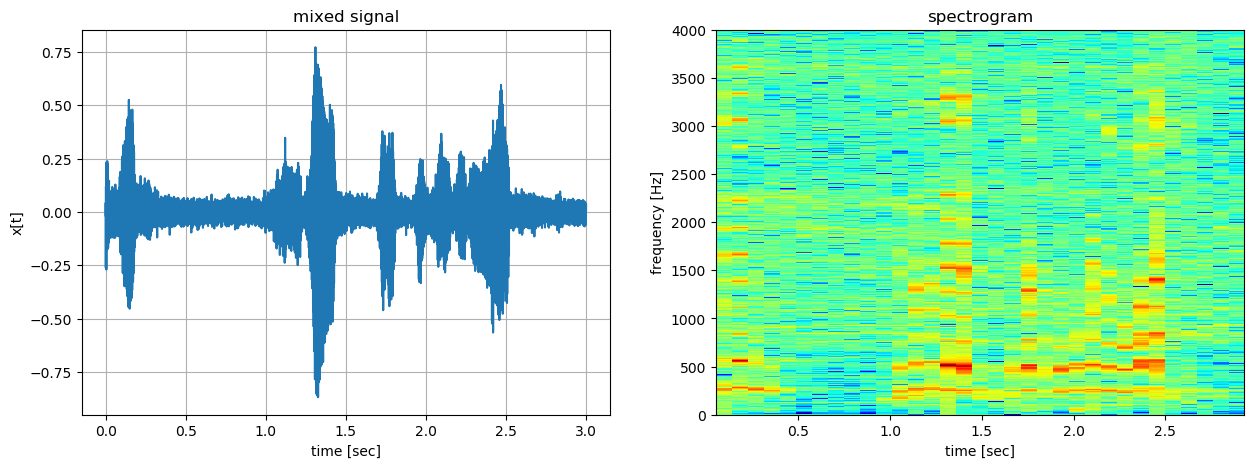

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_tot)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_tot, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("mixed signal"), ax[2].set_title("spectrogram")
;

## Warp signal and calculate warped frequency distribution

In [5]:
# initialize memory vector of taps, Y, with zeros
Y = zeros(nr_taps_warped*3,1)

# initialize memory struct for filter taps and spectrum coefficients
mem_taps = Array{Array{Float64,1}}(undef, length(x_tot))
mem_spec = Array{Complex{Float64},2}(undef, length(x_tot), nr_taps_warped)

# get update matrices as defined in thesis
W, U = allpass_update_matrix(nr_taps_warped, z_pole)

# loopt through time-domain signal
for k = 1:length(x_tot)
    
    # update memory vector of taps and taps themselves
    Y, mem_taps[k] = allpass_update(x_tot[k], Y, nr_taps_warped, z_pole, T=W, u=U)

    # calculate windowed FFT of taps
    mem_spec[k,:] = FFTW.fft(window(nr_taps_warped).*mem_taps[k])
    
end

# discard frequency components concerning non-positive frequencies (are complex conjugate, because of real temporal signal)
if nr_taps_warped%2 == 0
    mem_spec = hcat(mem_spec[:, 2:Int(nr_taps_warped/2)], conj.(mem_spec[:, Int(nr_taps_warped/2)+1]))
else
    mem_spec = mem_spec[:, 2:Int(ceil(nr_taps_warped/2))]
end

# calculate real and imaginary parts of remaining frequency components
mem_spec_real = real(mem_spec)
mem_spec_imag = imag(mem_spec)
;

In [6]:
# initialize memory vector of taps, Y, with zeros
Y1 = zeros(nr_taps_warped*3,1)

# initialize memory struct for filter taps and spectrum coefficients
mem_taps1 = Array{Array{Float64,1}}(undef, length(x_1))
mem_spec1 = Array{Complex{Float64},2}(undef, length(x_1), nr_taps_warped)

# get update matrices as defined in thesis
W, U = allpass_update_matrix(nr_taps_warped, z_pole)

# loopt through time-domain signal
for k = 1:length(x_1)
    
    # update memory vector of taps and taps themselves
    Y1, mem_taps1[k] = allpass_update(x_1[k], Y1, nr_taps_warped, z_pole, T=W, u=U)

    # calculate windowed FFT of taps
    mem_spec1[k,:] = FFTW.fft(window(nr_taps_warped).*mem_taps1[k])
    
end

# discard frequency components concerning non-positive frequencies (are complex conjugate, because of real temporal signal)
if nr_taps_warped%2 == 0
    mem_spec1 = hcat(mem_spec1[:, 2:Int(nr_taps_warped/2)], conj.(mem_spec1[:, Int(nr_taps_warped/2)+1]))
else
    mem_spec1 = mem_spec1[:, 2:Int(ceil(nr_taps_warped/2))]
end

# calculate real and imaginary parts of remaining frequency components
mem_spec_real1 = real(mem_spec1)
mem_spec_imag1 = imag(mem_spec1)

# select specified frequency bin
if bin_c == "real"
    spec_select1 = mem_spec_real1[:, bin]
else
    spec_select1 = mem_spec_imag1[:, bin]
end
;

In [7]:
# initialize memory vector of taps, Y, with zeros
Y2 = zeros(nr_taps_warped*3,1)

# initialize memory struct for filter taps and spectrum coefficients
mem_taps2 = Array{Array{Float64,1}}(undef, length(x_2))
mem_spec2 = Array{Complex{Float64},2}(undef, length(x_2), nr_taps_warped)

# get update matrices as defined in thesis
W, U = allpass_update_matrix(nr_taps_warped, z_pole)

# loopt through time-domain signal
for k = 1:length(x_2)
    
    # update memory vector of taps and taps themselves
    Y2, mem_taps2[k] = allpass_update(x_2[k], Y2, nr_taps_warped, z_pole, T=W, u=U)

    # calculate windowed FFT of taps
    mem_spec2[k,:] = FFTW.fft(window(nr_taps_warped).*mem_taps2[k])
    
end

# discard frequency components concerning non-positive frequencies (are complex conjugate, because of real temporal signal)
if nr_taps_warped%2 == 0
    mem_spec2 = hcat(mem_spec2[:, 2:Int(nr_taps_warped/2)], conj.(mem_spec2[:, Int(nr_taps_warped/2)+1]))
else
    mem_spec2 = mem_spec2[:, 2:Int(ceil(nr_taps_warped/2))]
end

# calculate real and imaginary parts of remaining frequency components
mem_spec_real2 = real(mem_spec2)
mem_spec_imag2 = imag(mem_spec2)

# select specified frequency bin
if bin_c == "real"
    spec_select2 = mem_spec_real2[:, bin]
else
    spec_select2 = mem_spec_imag2[:, bin]
end
;

## Warped spectral distribution visualization

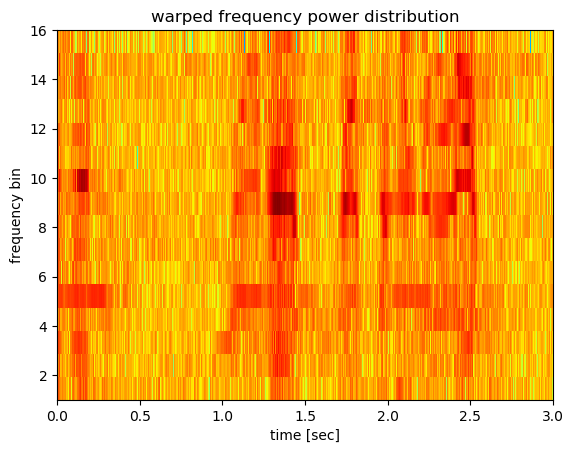

In [8]:
# calculate power of spectral components
mem_spec_pwr = 20*log10.(abs.(mem_spec))'

# plot warped power spectrum
plt.imshow(mem_spec_pwr, aspect="auto", cmap="jet", origin="lower", extent=[t[1], t[end], 1, Int(floor(nr_taps_warped/2))]), plt.xlabel("time [sec]"), plt.ylabel("frequency bin"), plt.title("warped frequency power distribution")
;

## Single bin visualization

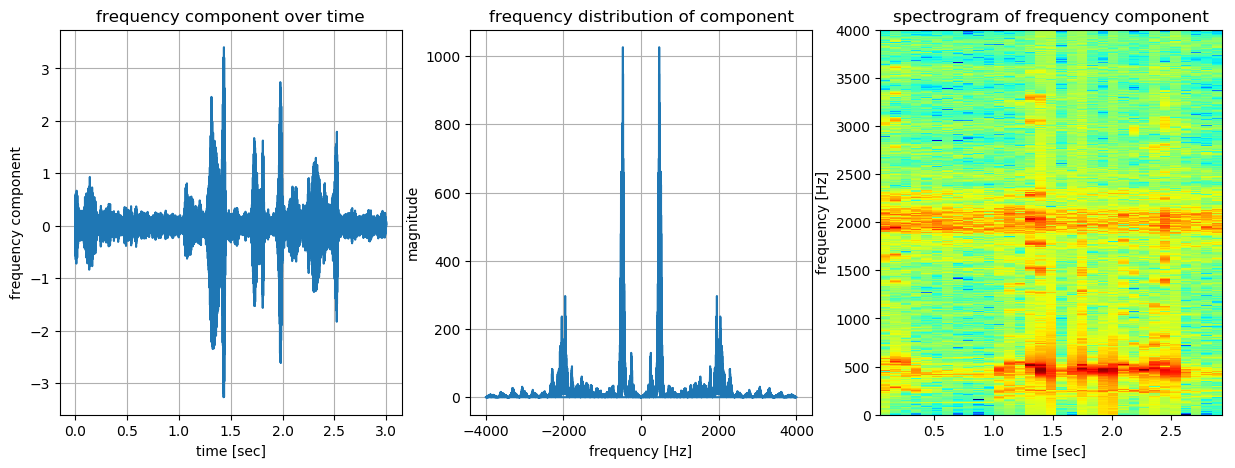

In [9]:
# select specified frequency bin
if bin_c == "real"
    spec_select = mem_spec_real[:, bin]
else
    spec_select = mem_spec_imag[:, bin]
end

# create subplots
_, ax = plt.subplots(ncols=3, figsize=(15,5))

# plot frequency component as a function of time
ax[1].plot(t, spec_select)

# plot frequency distribution of frequency component
ax[2].plot(FFTW.fftfreq(length(spec_select), fs_desired), abs.(FFTW.fft(spec_select)))

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(spec_select, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[3])

# change visuals
ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency component"), ax[1].set_title("frequency component over time"), ax[2].grid(), ax[2].set_xlabel("frequency [Hz]"), ax[2].set_ylabel("magnitude"), ax[2].set_title("frequency distribution of component"), ax[3].set_title("spectrogram of frequency component")
;

## Load parameters

In [10]:
if bin_c == "real"
    params_1 = h5read(param_file_1, "bin_real_"*string(bin, pad=2))
    params_2 = h5read(param_file_2, "bin_real_"*string(bin, pad=2))
else
    params_1 = h5read(param_file_1, "bin_imag_"*string(bin, pad=2))
    params_2 = h5read(param_file_2, "bin_imag_"*string(bin, pad=2))    
end
;

## Create generative model and algorithm

In [11]:
# create factor graphs
fg = FactorGraph()

# AR node (source 1)
@RV γ1 ~ ForneyLab.Gamma(params_1["gamma_a"], params_1["gamma_b"])
@RV θ1 ~ GaussianMeanPrecision(params_1["theta_mean"], params_1["theta_precision"])
@RV Sprev1 ~ GaussianMeanPrecision(placeholder(:μ_Sprev1, dims=(AR_order,)), placeholder(:Λ_Sprev1, dims=(AR_order, AR_order)))
@RV S1 ~ LAR.AR.Autoregressive(θ1, Sprev1, γ1)

# AR node (source 1)
@RV γ2 ~ ForneyLab.Gamma(params_2["gamma_a"], params_2["gamma_b"])
@RV θ2 ~ GaussianMeanPrecision(params_2["theta_mean"], params_2["theta_precision"])
@RV Sprev2 ~ GaussianMeanPrecision(placeholder(:μ_Sprev2, dims=(AR_order,)), placeholder(:Λ_Sprev2, dims=(AR_order, AR_order)))
@RV S2 ~ LAR.AR.Autoregressive(θ2, Sprev2, γ2)

# selection and input
d = zeros(AR_order)
d[1] = 1
@RV x1 ~ DotProduct(d, S1)
@RV x2 ~ DotProduct(d, S2)

@RV v ~ GaussianMeanPrecision(0, Λ_meas)
@RV y = x1 + x2 + v
placeholder(y, :y)


ForneyLab.draw(fg)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 5175272087314116290 -->
 5175272087314116290 
 
 clamp_10 
 
<!-- 7121963002251285931 -->
 7121963002251285931 
 
 placeholder_μ_Sprev2 
 
<!-- 18252218023834066854 -->
 18252218023834066854 
 
 clamp_7 
 
<!-- 4606530235012186393 -->
 4606530235012186393 
 
 placeholder_μ_Sprev1 
 
<!-- 12461807421201093852 -->
 12461807421201093852 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 12461807421201093852--4606530235012186393 -->
 12461807421201093852--4606530235012186393 
 
 μ_Sprev1 
 1 out 
 2 m 
 
<!-- 15456154698249237087 -->
 15456154698249237087 
 
 placeholder_Λ_Sprev1 
 
<!-- 12461807421201093852--15456154698249237087 -->
 12461807421201093852--15456154698249237087 
 
 Λ_Sprev1 
 1 out 
 3 w 
 
<!-- 3017189090601951822 -->
 3017189090601951822 
 
 clamp_1 
 
<!-- 11383498324375895428 -->
 11383498324375895428 
 
 clamp_2 
 
<!-- 18078132485112629286 -->
 18078132485112629286 
 
 AR 
 autoregressive_2 
 
<!-- 44847409050188831 -->
 44847409050188831 
 
 𝒩 
 gaussianmeanprecision_4 
 
<!-- 18078132485112629286--44847409050188831 -->
 18078132485112629286--44847409050188831 
 
 Sprev2 
 1 out 
 2 x 
 
<!-- 1598122446189654224 -->
 1598122446189654224 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 18078132485112629286--1598122446189654224 -->
 18078132485112629286--1598122446189654224 
 
 θ2 
 1 out 
 3 θ 
 
<!-- 3744769308858646665 -->
 3744769308858646665 
 
 Gam 
 gamma_2 
 
<!-- 18078132485112629286--3744769308858646665 -->
 18078132485112629286--3744769308858646665 
 
 γ2 
 1 out 
 4 γ 
 
<!-- 9626594588196994755 -->
 9626594588196994755 
 
 placeholder_Λ_Sprev2 
 
<!-- 17918213986201718604 -->
 17918213986201718604 
 
 dot 
 dotproduct_2 
 
<!-- 17918213986201718604--5175272087314116290 -->
 17918213986201718604--5175272087314116290 
 
 clamp_10 
 1 out 
 2 in1 
 
<!-- 17918213986201718604--18078132485112629286 -->
 17918213986201718604--18078132485112629286 
 
 S2 
 1 y 
 3 in2 
 
<!-- 44847409050188831--7121963002251285931 -->
 44847409050188831--7121963002251285931 
 
 μ_Sprev2 
 1 out 
 2 m 
 
<!-- 44847409050188831--9626594588196994755 -->
 44847409050188831--9626594588196994755 
 
 Λ_Sprev2 
 1 out 
 3 w 
 
<!-- 6297533437961045699 -->
 6297533437961045699 
 
 clamp_11 
 
<!-- 1598122446189654224--18252218023834066854 -->
 1598122446189654224--18252218023834066854 
 
 clamp_7 
 1 out 
 2 m 
 
<!-- 15479384260764661207 -->
 15479384260764661207 
 
 clamp_8 
 
<!-- 1598122446189654224--15479384260764661207 -->
 1598122446189654224--15479384260764661207 
 
 clamp_8 
 1 out 
 3 w 
 
<!-- 4724050373527191770 -->
 4724050373527191770 
 
 clamp_12 
 
<!-- 8480036611706929696 -->
 8480036611706929696 
 
 dot 
 dotproduct_1 
 
<!-- 3656008975666095258 -->
 3656008975666095258 
 
 clamp_9 
 
<!-- 8480036611706929696--3656008975666095258 -->
 8480036611706929696--3656008975666095258 
 
 clamp_9 
 1 out 
 2 in1 
 
<!-- 18209627418667748870 -->
 18209627418667748870 
 
 AR 
 autoregressive_1 
 
<!-- 8480036611706929696--18209627418667748870 -->
 8480036611706929696--18209627418667748870 
 
 S1 
 1 y 
 3 in2 
 
<!-- 5807387534938608539 -->
 5807387534938608539 
 
 + 
 addition_2 
 
<!-- 10821116392636923476 -->
 10821116392636923476 
 
 + 
 addition_1 
 
<!-- 5807387534938608539--10821116392636923476 -->
 5807387534938608539--10821116392636923476 
 
 variable_1 
 1 out 
 2 in1 
 
<!-- 17926381875826498366 -->
 17926381875826498366 
 
 𝒩 
 gaussianmeanprecision_5 
 
<!-- 5807387534938608539--17926381875826498366 -->
 5807387534938608539--17926381875826498366

In [12]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(S1, Sprev1, x1, S2, Sprev2, x2, ids=[:S1 :Sprev1 :x1 :S2 :Sprev2 :x2])
algo = compatibility_fix(variationalAlgorithm(q))

# evaluate algorithm
eval(Meta.parse(algo))
;

## Perform inference

In [13]:
# priors
current1_μ_Sprev = randn(AR_order)
current1_Λ_Sprev = tiny*diagm(randn(AR_order))
current2_μ_Sprev = randn(AR_order)
current2_Λ_Sprev = tiny*diagm(randn(AR_order))
current1_μ_x = randn(1)
current1_Λ_x = tiny
current2_μ_x = randn(1)
current2_Λ_x = tiny

# placeholders for predictions
x1_μ_pred = Float64[]
x1_Λ_pred = Float64[]
x2_μ_pred = Float64[]
x2_Λ_pred = Float64[]

# progress bar
p = Progress(length(spec_select), 1, "Observed ")

# initialize marginals and data dictionary
marginals = Dict()
data = Dict()

# loop through signal samples
for sp in 1:length(spec_select)
    
    # update progress bar
    update!(p, sp)
    
    # update marginals
    marginals[:θ1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_1["theta_mean"], w=params_1["theta_precision"])
    marginals[:γ1] = ProbabilityDistribution(Univariate, Gamma, a=params_1["gamma_a"], b=params_1["gamma_b"])
    marginals[:Sprev1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=current1_μ_Sprev, w=current1_Λ_Sprev)
    marginals[:x1] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=current1_μ_x, w=current1_Λ_x)
    marginals[:θ2] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_2["theta_mean"], w=params_2["theta_precision"])
    marginals[:γ2] = ProbabilityDistribution(Univariate, Gamma, a=params_2["gamma_a"], b=params_2["gamma_b"])
    marginals[:Sprev2] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=current2_μ_Sprev, w=current2_Λ_Sprev)    
    marginals[:x2] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=current2_μ_x, w=current2_Λ_x)
    
    # perform VMP iterations
    for it = 1:iterations
        
        # update data dictionary
        data = Dict(:y => spec_select[sp],
                    :μ_Sprev1 => current1_μ_Sprev,
                    :Λ_Sprev1 => current1_Λ_Sprev,
                    :μ_Sprev2 => current2_μ_Sprev,
                    :Λ_Sprev2 => current2_Λ_Sprev)      
        
        # perform inference
        data, marginals = step_all!(data, marginals)
        
        # update current parameters
        current1_μ_Sprev = ForneyLab.unsafeMean(marginals[:Sprev1])
        current1_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:Sprev1])
        current2_μ_Sprev = ForneyLab.unsafeMean(marginals[:Sprev2])
        current2_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:Sprev2])
        current1_μ_x = ForneyLab.unsafeMean(marginals[:x1])
        current1_Λ_x = ForneyLab.unsafePrecision(marginals[:x1])
        current2_μ_x = ForneyLab.unsafeMean(marginals[:x2])
        current2_Λ_x = ForneyLab.unsafePrecision(marginals[:x2])

    end
    
    # update current parameters
    current1_μ_Sprev = ForneyLab.unsafeMean(marginals[:S1])
    current1_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:S1])
    current2_μ_Sprev = ForneyLab.unsafeMean(marginals[:S2])
    current2_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:S2])
    
    # save predictions of separation
    push!(x1_μ_pred, current1_μ_x)
    push!(x1_Λ_pred, current1_Λ_x)
    push!(x2_μ_pred, current2_μ_x)
    push!(x2_Λ_pred, current2_Λ_x)    
end
;

Observed 100%|██████████████████████████████████████████| Time: 0:03:26m


## Drilling sound

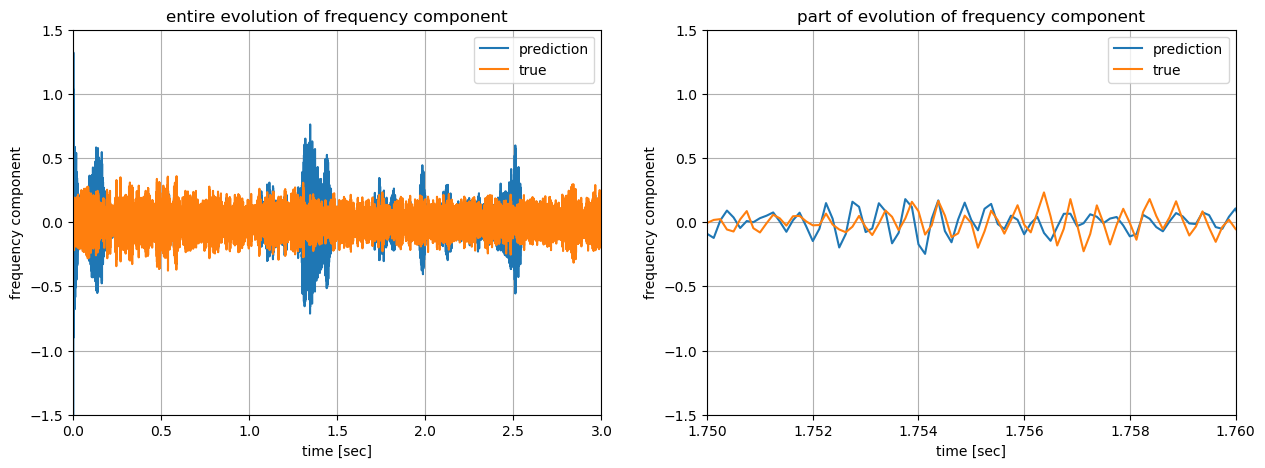

In [14]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot prediction of frequency component
ax[1].plot(t[1:end], x1_μ_pred[1:end], label="prediction"), ax[2].plot(t[1:end], x1_μ_pred[1:end], label="prediction")

# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t[1:end], spec_select1[1:end], label="true"), ax[2].plot(t[1:end], spec_select1[1:end], label="true") 

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency component"), ax[1].set_title("entire evolution of frequency component"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("frequency component"), ax[2].set_title("part of evolution of frequency component")
ax[2].set_xlim(1.75, 1.76), ax[2].set_ylim(-1.5,1.5), ax[1].set_ylim(-1.5,1.5)
;

## Speech 

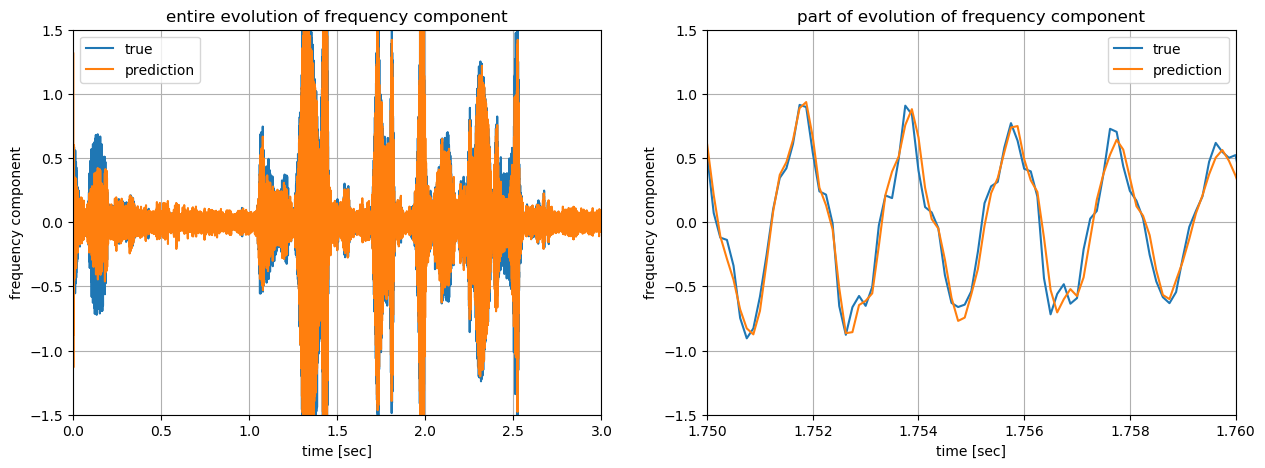

In [15]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))


# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t[1:end], spec_select2[1:end], label="true"), ax[2].plot(t[1:end], spec_select2[1:end], label="true") 
# plot prediction of frequency component
ax[1].plot(t[1:end], x2_μ_pred[1:end], label="prediction"), ax[2].plot(t[1:end], x2_μ_pred[1:end], label="prediction")

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency component"), ax[1].set_title("entire evolution of frequency component"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("frequency component"), ax[2].set_title("part of evolution of frequency component")
ax[2].set_xlim(1.75, 1.76), ax[2].set_ylim(-1.5,1.5), ax[1].set_ylim(-1.5,1.5)
;